# This Document is the detail explanation of the code for Normalizing Flow

For detail theory background of this method, refer to the paper https://arxiv.org/abs/1505.05770

In real engineering problems, we often use variational inference to simulate a complex posterior distribution in a numerical way.\
The reason why it is hard for us to calculate the posterior using Bayesian Theorem is that the denominator of\
$$
   p(z|x)=\frac{p(z)p(x|z)}{\int p(x|z)dz} 
$$
is hard to compute when x,z are n-dimensional variables (because the multiple integral is very hard to compute)\
To solve this problem, there are mainly 2 approach.\
1. Marcov Chain Monte Carclo Simution (MCNC) Maybe Matroplis-Hasting Algorithm or Gibbs Sampling
2. Variational Inference

In machine learning projects, we often choose the second approach, because it converts the above problem to be an optimization problem which we have a lot of  optimizer to deal with it.\
The basic idea of variational inference is to construct another distribution $q(z|x)$ which is controlled by a parameter $\phi$, we keep on updating the $q$ until it get close to $p$.\
The normalizing flow is a kind of technique based on variable transformation.\
Given a variable $z_0$ and we perform a sequence of transformations on it and we can make the PDF of z similar to a complex mutidimensional target distribution.\
What is special in this techinique is that we do not need to know the exact expression for $q_k$ when we compute the expectation on $q_k$,since\
$$
\begin{aligned}
\mathbf{z}_K & =f_K \circ \ldots \circ f_2 \circ f_1\left(\mathbf{z}_0\right) \\
\ln q_K\left(\mathbf{z}_K\right) & =\ln q_0\left(\mathbf{z}_0\right)-\sum_{k=1}^K \ln \left|\operatorname{det} \frac{\partial f_k}{\partial \mathbf{z}_{k-1}}\right|
\end{aligned}
$$

There are two important things we need to implement in the normalizing flow:
1. The Flow Process itself, here we choose planar flow
2. The loss function, which is called Free-Energy-Bound

In [1]:
#Requirment
import torch 
import os
from torch import nn
from torch.nn import functional as F
import argparse
from torch.autograd import Variable
from torch import optim
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

C:\Users\aa219040\anaconda3\envs\ece471\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In the following part, flow process is implemented.\ 
First is the main normalizing flow. It is consist of K(flow length: how many transforms does the transformation sequence need to have to make $q$ similar to $p$) Plannar Flow Layer, ofcourse, we must calculate the Jacobian of these transforms like what ECE4010J did in regular lecture. 

In [2]:
class Normalizing_Flow(nn.Module):
    '''
    In a normalizing flow, we need to get 2 things
    1. The transform itself
    2. The Jacobian
    '''
    def __init__(self,dimension,flow_length) -> None:
        super().__init__()
        self.dimension = dimension
        self.transformation = nn.Sequential(*(Planar_Flow(self.dimension) for k in range (flow_length)))
        self.Jacobian = nn.Sequential(*(Planar_Flow_Jacobian(f) for f in self.transformation))
    
    def forward(self,z):
        log_jacobian = []
        for transform,jacobian in zip(self.transformation,self.Jacobian):
            log_jacobian.append(jacobian(z))
            z=transform(z)
        zk = z
        return zk,log_jacobian

The following code shows the implementation of Planar flow.\
Note the F.linear will return $w^Tz+b$\
Here the activation function will be chosen as tanh, we may not use relu, because the paper says the function $h$ showed be smooth piece-wise. And the derivative of tanh is easy to compute.\
The following block actually implement the formula:
$$
f(\mathbf{z})=\mathbf{z}+\mathbf{u} h\left(\mathbf{w}^{\top} \mathbf{z}+b\right)
$$

In [3]:
class Planar_Flow(nn.Module):
    '''
    In the planar_flow, we need first to initiate weight , bias and coefficient which are 
    w,b,u in the paper.
    '''
    def __init__(self,dimension) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(1,dimension))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.u = nn.Parameter(torch.Tensor(1,dimension))
        self.set_param()

    def set_param(self):
        self.weight.data.uniform_(-0.01,0.01)
        self.bias.data.uniform_(-0.01,0.01)
        self.u.data.uniform_(-0.01,0.01)

    def forward(self,z):
       # print(z.shape,self.weight.shape)
        F.linear(z,self.weight,self.bias)
        f_z = z + self.u*F.tanh(F.linear(z,self.weight,self.bias)) # f(z)= z + u*h(w^Tz+b) ##Question, could the activate function be changed to relu?
        return f_z

The following code implement the Jacobian of a certain transformation. The formula implemented here is:
$$
\begin{gathered}
\psi(\mathbf{z})=h^{\prime}\left(\mathbf{w}^{\top} \mathbf{z}+b\right) \mathbf{w} \\
\left|\operatorname{det} \frac{\partial f}{\partial \mathbf{Z}}\right|=\left|\operatorname{det}\left(\mathbf{I}+\mathbf{u} \psi(\mathbf{z})^{\top}\right)\right|=\left|1+\mathbf{u}^{\top} \psi(\mathbf{z})\right|
\end{gathered}
$$
Look at the line emphasized. That "1-F.tanh(tmp))**2", is because $tanh(x)'=1-tanh(x)^2$\
And the $h$ as we have discussed above, is tanh, the activate function.

In [4]:
class Planar_Flow_Jacobian(nn.Module):
    def __init__(self,transform) -> None:
        super().__init__()
        self.weight = transform.weight
        self.bias = transform.bias
        self.u = transform.u

    def forward(self,z):
        tmp = F.linear(z,self.weight,self.bias)
        psi_z = (1-(F.tanh(tmp))**2)*self.weight ###Note!!###
        Jacobian = 1 + torch.mm(psi_z,self.u.t())
        return torch.log(Jacobian.abs()+1e-8)

After this. Loss function can be implemented
$$
\begin{aligned}
\mathcal{F}(\mathbf{x}) & =\mathbb{E}_{q_\phi(z \mid x)}\left[\log q_\phi(\mathbf{z} \mid \mathbf{x})-\log p(\mathbf{x}, \mathbf{z})\right] \\
& =\mathbb{E}_{q_0\left(z_0\right)}\left[\ln q_K\left(\mathbf{z}_K\right)-\log p\left(\mathbf{x}, \mathbf{z}_K\right)\right] \\
& =\mathbb{E}_{q_0\left(z_0\right)}\left[\ln q_0\left(\mathbf{z}_0\right)\right]-\mathbb{E}_{q_0\left(z_0\right)}\left[\log p\left(\mathbf{x}, \mathbf{z}_K\right)\right] \\
& -\mathbb{E}_{q_0\left(z_0\right)}\left[\sum_{k=1}^K \ln \left|1+\mathbf{u}_k^{\top} \psi_k\left(\mathbf{z}_{k-1}\right)\right|\right]
\end{aligned}
$$
.mean() means expectation you know.

In [5]:
class FreeEnergyBound(nn.Module):

    def __init__(self, density):
        super().__init__()

        self.density = density

    def forward(self, zk, log_jacobians):
        #print(log_jacobians)
        sum_of_log_jacobians = sum(log_jacobians)
        return (-sum_of_log_jacobians - torch.log(self.density(zk))+1e-8).mean()

Then, experiment and visuallization

In [6]:
def scatter_points(points, directory, iteration, flow_length):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)
    ax.set_title(
        "Flow length: {}\n Samples on iteration #{}"
        .format(flow_length, iteration)
    )

    fig.savefig(os.path.join(directory, "flow_result_{}.png".format(iteration)))
    plt.close()


def plot_density(density, directory):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1 = x1.ravel()
    x2 = x2.ravel()

    z = np.c_[x1, x2]
    z = torch.FloatTensor(z)
    z = Variable(z)

    density_values = density(z).data.numpy().reshape(shape)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.imshow(density_values, extent=(*X_LIMS, *Y_LIMS), cmap="summer")
    ax.set_title("True density")

    fig.savefig(os.path.join(directory, "density.png"))
    plt.close()

In [15]:
def random_normal_samples(n, dim=2):
    return torch.zeros(n, dim).normal_(mean=0, std=1)

def p_z(z):

    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)

    return torch.exp(-u)


parser = argparse.ArgumentParser(
    formatter_class=argparse.ArgumentDefaultsHelpFormatter
)

parser.add_argument(
    "--log_interval", type=int, default=300,
    help="How frequenlty to print the training stats."
)
parser.add_argument(
    "--plot_interval", type=int, default=500,
    help="How frequenlty to plot samples from current distribution."
)
parser.add_argument(
    "--plot_points", type=int, default=1000,
    help="How many to points to generate for one plot."
)

#args = parser.parse_args()
args = parser.parse_args([])# for jupyter notebook, the above one will go error, but for .py use the first one
torch.manual_seed(42)

##Hyper parameters###
batch_size= 40
iterations = 10000
lr = 0.01
lr_decay = 0.999
flow_length = 16
name = 'planar'
#####

flow = Normalizing_Flow(dimension=2, flow_length=flow_length)
bound = FreeEnergyBound(density=p_z)
optimizer = optim.RMSprop(flow.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

plot_density(p_z, directory='./distribution')

def should_log(iteration):
    return iteration % args.log_interval == 0

def should_plot(iteration):
    return iteration % args.plot_interval == 0

for iteration in tqdm(range(1, iterations + 1)):

    scheduler.step()

    samples = Variable(random_normal_samples(batch_size))
    zk, log_jacobians = flow(samples)

    optimizer.zero_grad()
    loss = bound(zk, log_jacobians)
    loss.backward()
    optimizer.step()

    if should_plot(iteration) or iteration==1:
            samples = Variable(random_normal_samples(args.plot_points))
            zk, det_grads = flow(samples)
            scatter_points(
                zk.data.numpy(),
                directory='./samples',
                iteration=iteration,
                flow_length=flow_length
            )

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\aa219040\anaconda3\envs\ece471\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
C:\Users\aa219040\anaconda3\envs\ece471\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|███████████████████████████████████████████████████████████████████████

See the result.

In [10]:
from PIL import Image

In [11]:
true_density = Image.open('./distribution/density.png') 

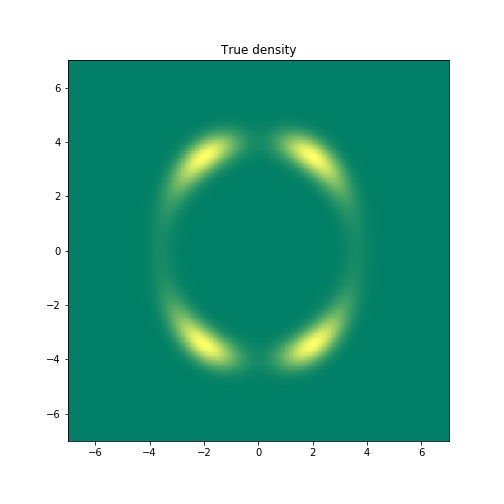

In [13]:
true_density 

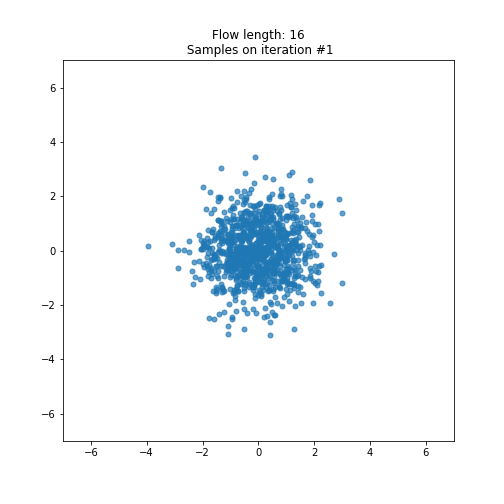

In [38]:
start_density = Image.open('./samples/flow_result_1.png')
mid1_density = Image.open('./samples/flow_result_500.png')
mid2_density = Image.open('./samples/flow_result_5000.png')
final_density = Image.open('./samples/flow_result_10000.png')
start_density


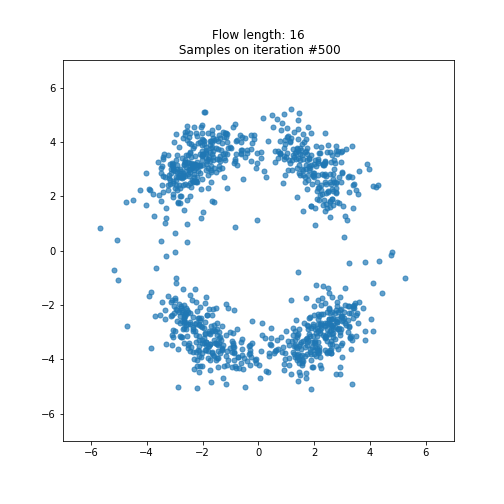

In [39]:
mid1_density

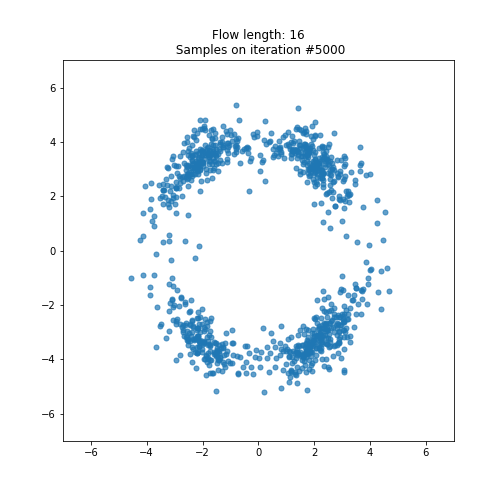

In [40]:
mid2_density

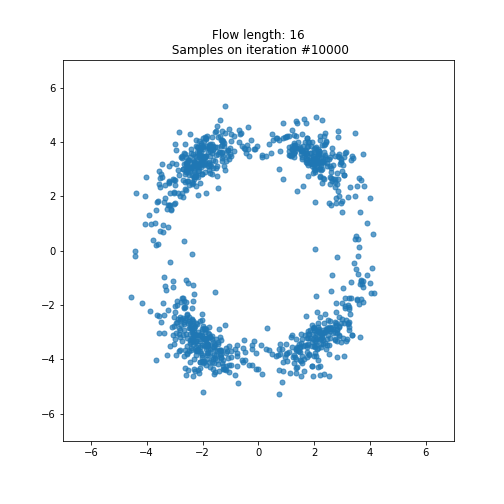

In [42]:
final_density